## Trends In Song Lyrics Through The Decades ##
#### Kerwin Chen ####

### Introduction ###

As a consumer of music from different decades, I was interested in seeing how songs have evolved and developed over time. In my project, I focused on song lyrics, seeking to understand how song lyrics have changed over the decades, from the 1960's to 2010's, by both looking at whether there were any changes to average lyric length, and identifying characteristic terms in song lyrics from each decade. 
I found via multiple hypothesis tests with adjusted $\alpha$ levels that there was a significant increase in song length as we move from the 1960's to the 2000's, and then a dip in the 2010's, though still higher than the 1990's. This may suggest changes in song lengths, or changes in how fast words are spoken, which future analysis can illuminate.<br>
Through a logistic regression model with terms as predictors and decade as output, I extracted and found the key terms for each decade as follows:<br>
__Characteristic terms for the 1960's:__ darling, loneliness, heartaches, untrue, clown, kissed, arms<br>
__Characteristic terms for the 1970's:__ behind, lord, woman, sorrow<br>
__Characteristic terms for the 1980's:__ shatter, near, hearts, resist, lasts, clover, jamming, romance, fantasy<br>
__Characteristic terms for the 1990's:__ pain, step, speak, inside, brothers, yo, loves, confess, silence<br>
__Characteristic terms for the 2000's:__ wanna, three, thang, wishing, club, butterflies, taken, waking, breathe<br>
__Characteristic terms for the 2010's:__ i'ma, dark, broke, couch, hate, beautiful, fuckin', shit, missing, wasted, tryna, already<br>

I notice certain themes arise in these characteristic terms, eg in the 1960's, more emotional and affectionate terms, while the 2010's have darker and more aggressive terms. Future sentiment analysis can reveal thematic trends in song lyrics through the decades.

### Data Description ###
This dataset was created by me through a series of web scrapings. No human participants were involved in the data collection.<br> Link to the data can be found [here](https://github.com/mrkerwinchen/2950_proj/blob/master/clean_lyrics.csv).<br>
__What are the observations (rows) and the attributes (columns)?__ <br>
Each row represents a single song from a given decade, and the attributes include the decade of the song, the year, the song name, artist name, as well as its lyrics.<br>
__What processes might have influenced what data was observed and recorded and what was not?__<br>
Because the creators of the data (Billboard) isn't involved with the music itself, I feel that it's able to maintain a pretty objective perspective because its ranking is based on a public function of music popularity and cumulative sales. <br>
__What preprocessing was done, and how did the data come to be in the form that you are using?__<br>
I obtained this dataset by first scraping for the top 100 songs of each year from Billboard Hot 100, from 1960 to 2019. Using this, I scraped for the lyrics for each of these songs and obtained the final dataset after a combination of inspection and cleaning of the lyrics and a few iterations of lyric scrapings. Processing of the lyrics occurred after each round of scraping.

### Preregistered Analysis ###
1. Compare the means of the song lengths across the decade, and determine whether the length of song lyrics have changed
2. Create a regression model to predict the decade of a song given lyrics, and determine characteristic terms for each decade

### Data Analysis ###

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
import lyricsgenius as lg
from patsy.builtins import Q
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.formula.api as smf
import scipy.stats as stat

In [2]:
data = pd.read_csv("clean_lyrics.csv", index_col = 0)
data.head()

,decade,year,artist,song,lyrics
0,1960,1960,Jim Reeves,He’ll Have To Go,put your sweet lips a little closer to the pho...
1,1960,1960,Everly Brothers,Cathy’s Clown,don't want your love any more don't want your ...
2,1960,1960,Elvis Presley,It’s Now Or Never,it's now or never come hold me tight kiss me m...
3,1960,1960,Elvis Presley,Stuck On You,you can shake an apple off an apple tree shake...
4,1960,1960,Chubby Checker,The Twist,come on baby let's do the twist come on baby l...


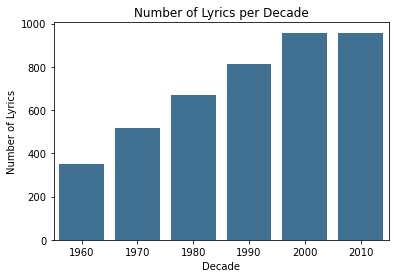

In [3]:
decade_group = data.groupby("decade")
decades = decade_group.groups.keys()
num_lyrics = sns.barplot(x = list(decades), y = decade_group.count()["lyrics"], color = (50/255, 116/255, 161/255))
num_lyrics.set(xlabel = "Decade", ylabel = "Number of Lyrics", title = "Number of Lyrics per Decade")
plt.show()

From the graph, I see that the preprocessing of the dataset left me with an uneven amount of lyrics across the decade, noteably less in older decades and more in modern decades. Moving forward, when looking at the prevalence of terms, I will report not raw frequencies, but percent frequency of terms amongst all the terms in a given decade.

In [4]:
#add a column of word counts to each song
word_count = [len(data["lyrics"][i].split()) for i in data.index]
data["word_count"] = word_count

In [5]:
#count_bydec is a dictionary with decades as keys and dictionary-like Counter objects of word counts for each decade as values
count_bydec = {}
for i in decades:
    count_bydec[i] = Counter(' '.join(decade_group.get_group(i).lyrics).split())

In [6]:
#sum_word_count is a dictionary with decades as keys and total word count for each decade as values
sum_word_count = {}
for i in count_bydec:
    sum_word_count[i] = sum(count_bydec[i].values())

In [7]:
decade_group_mean = data.groupby("decade").mean()
for decade in sum_word_count:
    print(f'{decade}\'s:  mean word count: {int(decade_group_mean.loc[decade]["word_count"].round())} | ' + 
          f'total word count: {sum_word_count[decade]}')

1960's:  mean word count: 225 | total word count: 78977
1970's:  mean word count: 267 | total word count: 137716
1980's:  mean word count: 298 | total word count: 199073
1990's:  mean word count: 407 | total word count: 330924
2000's:  mean word count: 490 | total word count: 469147
2010's:  mean word count: 447 | total word count: 426594


As suspected, with the increase in number of songs across the decades, the more modern decades have more total words. However, when we look at the mean word count, we also see a general increase, though with a dip from the 2000's to 2010's. To determine whether the differences in mean are significant, I will run hypothesis tests between each decade. To do so, I will plot the word count distribution and tabulate the variances to determine which hypothesis test would be appropriate.

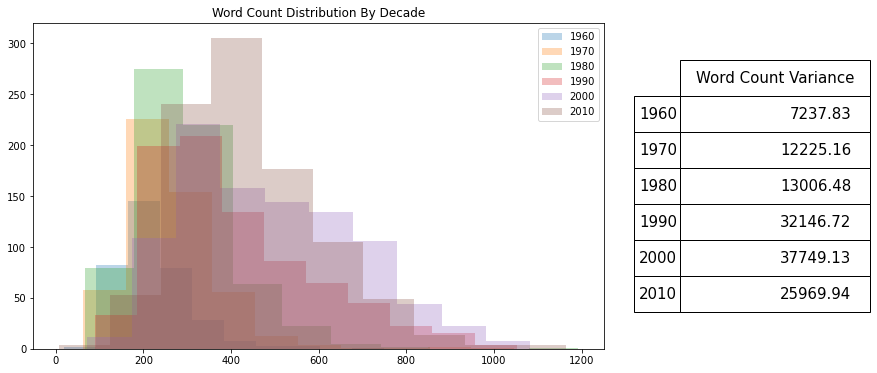

In [8]:
decade_group_var = data.groupby("decade").var()
fig, axs = plt.subplots(1, 2, figsize = (15, 6), gridspec_kw={'width_ratios': [3, 1]})
[axs[0].hist(data = data.loc[data.decade == i], x = "word_count", alpha = 0.3) for i in range(1960, 2020, 10)]
axs[0].legend(range(1960, 2020, 10))
axs[0].set_title("Word Count Distribution By Decade")
decade_group_var = decade_group_var.rename(columns = {"word_count" : "Word Count Variance"})
table = pd.plotting.table(axs[1], data = decade_group_var[["Word Count Variance"]].round(2), 
                          loc="center", colWidths = [1])
table.scale(1, 3)
table.set_fontsize(20)
axs[1].axis("off")
plt.show()

The distribution of the word counts seem pretty normal overall, though there does seem to be a slight skewing to the right. The variances are also noticeably different. One of the assumptions of the two-sample t-test is the sample being normally distributed, and although there is that slight skewing, the test is pretty robust so it seems appropriate to use in this case.

In general, $\alpha = 0.05$ is used with hypothesis tests, representing the probability of a type I error, namely _rejecting_ the null hypothesis (in this case, $H_0 =$ no significant difference in mean), when theres no actual difference in mean. However, since multiple t-tests will be run, one for each pair of decades, $\alpha$ would be inflated, as one or more type I errors may be committed. To account for this, the $\alpha$ level for each individual test must be adjusted. Using a desired _familywise error rate_ of 0.05 for the series of all my hypothesis tests, I will calculate the adjusted individual $\alpha$ levels using the complement rule, subtracting the probability of not committing a type I error, $1-\alpha$, from 1.

$$\text{FWER} = 1 - (1 - \alpha_i)^n, \text{where FWER is the familywise error rate for n hypothesis tests with individual type I error rate } \alpha_i$$

With a desired familywise error rate of 0.05 and 6 decades from which we choose 2 decades to compare, we have as follows:

$$0.05 = 1 - (1 - \alpha_i)\strut^{6 \choose 2}$$
$$\alpha_i = 1 - (0.95)\strut^{\frac{1}{6 \choose 2}} = 1 - (0.95)\strut^{\frac{1}{15}}$$<br>
$$\alpha_i = 0.0034 = \text{3.4e-03}$$

With the adjusted individual $\alpha$ levels, I proceed with the hypothesis test.

In [9]:
ttests = [] #holder for p-value of each row of t-tests
for decade1 in range(1960, 2020, 10):
    ttests.append([np.format_float_scientific(stat.ttest_ind(data.loc[data.decade == decade1, "word_count"],
                                                             data.loc[data.decade == decade2, "word_count"], 
                                                             equal_var = False)[1], precision = 2)
                                              for decade2 in range(1960, 2020, 10)])

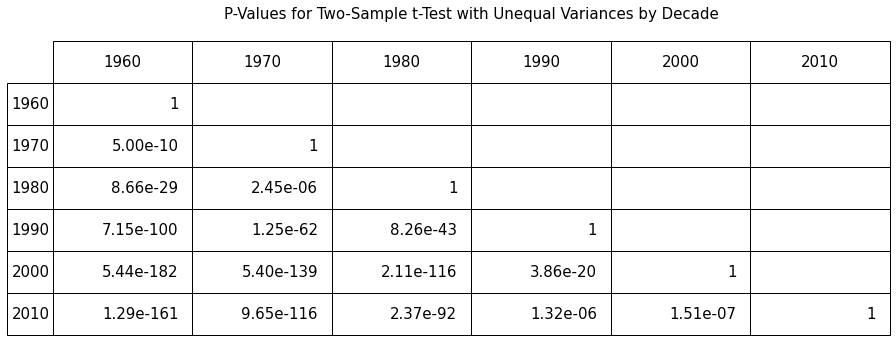

In [10]:
ttest_array = np.tril(np.array(ttests)) #keeps the lower triangle and removes the redundant upper triangle
for i in range(6):
    ttest_array[i, i] = int(float(ttest_array[i, i]))
fig, axs = plt.subplots(1, 1, figsize = (15, 6))
tab = axs.table(ttest_array, loc = 'center', colLabels = list(range(1960, 2020, 10)), rowLabels = list(range(1960, 2020, 10)))
tab.scale(1, 3.5)
tab.set_fontsize(15)
axs.axis("off")
axs.set_title("P-Values for Two-Sample t-Test with Unequal Variances by Decade", size=15)
plt.show()

I notice that between each decade, with $\alpha$ = 3.4e-03, since the p value is all less than my $\alpha$, there is a significant difference in the mean word count for song lyrics across every single decade. 

Following, I look at the words found in the songs across the decades.

In [11]:
#lambda function to censor words
censor = lambda x: x[0] + "*" + x[2:]
def word_plotter(axis, keywords, should_censor):
    '''plot keywords on given axis, censoring legend as appropriate'''
    for keyword in keywords:
        axis.plot(decades, [count_bydec[decade][keyword] / sum_word_count[decade] * 100 for decade in count_bydec])
    axis.legend([censor(word) for word in keywords] if should_censor else keywords)

In [12]:
def decade_plotter_2by3(keywords, keyword_names, global_ylabel, global_xlabel, subtitles, 
                        add_decadeLine = False, figwidth = 20, figheight = 10):
    '''plot given keywords on 2 by 3 plotting grid with each 1 of 6 subplot for a specific decade'''
    fig, axs = plt.subplots(2, 3, figsize = (figwidth, figheight))
    wordlist = 0
    #iteration through all the axis to plot each list of terms
    for ax in axs:
        for subax in ax:
            word_plotter(subax, keywords[wordlist], True if keyword_names[wordlist] == "Cuss" else False)
            if (add_decadeLine):
                subax.axvline(x = list(decades)[wordlist], color = "black", ls = "dotted")
            subax.set_title(subtitles.format(keyword_names[wordlist]))
            wordlist += 1

    axs[0, 0].set(ylabel = global_ylabel)
    axs[1, 0].set(ylabel = global_ylabel)
    axs[1, 0].set(xlabel = global_xlabel)
    axs[1, 1].set(xlabel = global_xlabel)
    axs[1, 2].set(xlabel = global_xlabel)
    plt.show()

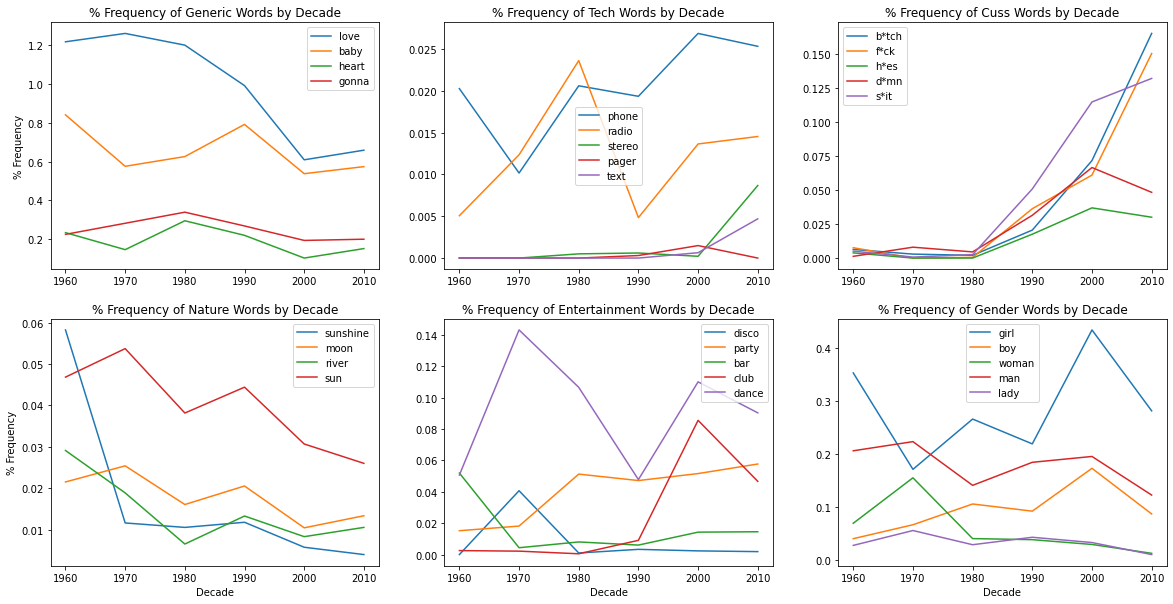

In [13]:
generic = ["love", "baby", "heart", "gonna"]
tech = ["phone", "radio", "stereo", "pager", "text"]
cuss = ["bitch","fuck", "hoes", "damn", "shit"]
nature = ["sunshine", "moon", "river", "sun"]
entertainment = ["disco", "party", "bar", "club", "dance"]
gender = ["girl", "boy", "woman", "man", "lady"]
keywords = [generic, tech, cuss, nature, entertainment, gender]
keyword_names = ["Generic", "Tech", "Cuss", "Nature", "Entertainment", "Gender"]
decade_plotter_2by3(keywords, keyword_names, "% Frequency", "Decade", '% Frequency of {} Words by Decade')

I selected a few words that I noticed from personal experience showed up in songs frequently, or represented a certain category of terms that I was interested in seeing the trends for across the decades. An interesting highlight is the percent frequency of cuss words by decade, as notice a general increase in percent frequency as we move to modern day. On the contrary, the percent frequency of nature words seem to decrease as we go across the decades, although not as rapidly in magnitude as cuss words. The rise of _disco_ in the 70's is reflected in song lyrics of that time as we can see a peak in the bottom center graph.

In [14]:
'''
scikit-learn's MultiLabelBinarizer conveniently allows me to create one-hot encoding from a list of lists (in my case,
a list of list of words from each song), which I use to create the dummy variable matrix to eventually feed into the
logistic regression.
'''
split_lyrics = [i.split() for i in data["lyrics"]]
mlb = MultiLabelBinarizer()
dummy = pd.DataFrame(mlb.fit_transform(split_lyrics))
dummy.columns = mlb.classes_

In [15]:
dummy.head()

,#1,#goals,$10,$100000,$20,$50,$50000,$7500,$hort,$ign,...,푸는,품격,하고픈게,하는건지,한잔의,해,허리,헉소리나게,화끈해야,﻿i
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I noticed that some of the terms were not words, and some of the terms were words in a different language. To reduce the number of dummy variables, I did some processing before using it in my logistic regression.

In [16]:
#stop_words contains stop words, ie common words like 'the', from the nltk library
stop_words = stopwords.words("english")
#removal of terms with no latin characters from the dummy variable
dummy = dummy.loc[:, dummy.columns[dummy.columns.str.match(r'[a-z]')]]
#removal of terms with non-english characters, as well as words with '-' and '$'
#from inspection, '-' came from terms like "l-l-l-l-love" and "l-l-l-l-l-l-love" which appeared in very little songs
#from inspection, '$' came from terms like "a$ap", which appeared in very limited songs
dummy = dummy.loc[:, [i.isascii() and "-" not in i and "$" not in i for i in dummy.columns]]
#removal of stop words
dummy = dummy.loc[:, [i not in stop_words for i in dummy.columns]]

In [17]:
dummy

,a&r's,a',a'jd,a's,a'standing,a'thuggin,a/c,a1,a1a,a6's,...,zoovier,zoowap,zorunda,zsa,zu,zucchinis,zuckerberg,zuhause,zulema,zum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#fed the dummy varriables into my logistic regression as predictors, and decade as output
reg = LogisticRegression(max_iter = 1000)
model = reg.fit(dummy, data["decade"])

In [19]:
'''
my regression model coef_ attribute contains the coefficients for each dummy variable. In order to find the dummy terms 
with the largest coefficients for each decade (ie the presence of the term has the largest increase in probability that the
song is from a certain decade), I used numpy's argpartition() function, which will essentially sort the k-th element into its
final position, with larger terms after it, and smaller terms before, and return a list of indices. I chose to look at the
top 15 terms with the largest coefficients from each decade
'''
topwords = [np.argpartition(model.coef_[i], -20)[-20:] for i in range(len(model.coef_))]

In [20]:
decade = 1960
key_terms = []
for i in topwords:
    #extracts the top terms for each decade from the dummy variables given the index position from argspartition()
    print(f'Key terms for {decade}\'s:\n{[dummy.columns[j] for j in i]}\n')
    key_terms.append([dummy.columns[j] for j in i])
    decade += 10

Key terms for 1960's:
['may', 'anyone', 'darling', 'hide', 'loneliness', 'pretty', 'whenever', 'heartaches', "hangin'", 'ah', 'listen', 'untrue', "she'd", 'longer', 'dear', 'went', 'everyday', 'clown', 'kissed', 'arms']

Key terms for 1970's:
['laying', "love's", 'ah', 'chills', "ridin'", 'single', 'cup', 'ha', 'wine', 'warm', 'behind', 'begun', 'spend', 'keeping', 'lord', 'woman', 'foolish', 'sorrow', 'fancy', 'yes']

Key terms for 1980's:
['shatter', 'flesh', 'heat', 'near', 'hearts', 'tease', 'must', 'stronger', 'resist', 'shining', 'gives', 'lasts', 'clover', 'tonight', 'jamming', 'romance', 'fantasy', 'stays', 'brighter', 'easier']

Key terms for 1990's:
['belong', 'pain', 'nerve', 'dreamed', 'gently', 'scream', 'boyfriend', 'blame', 'step', 'speak', 'vision', 'inside', 'secret', 'brothers', 'yo', 'loves', 'evening', 'confess', 'hat', 'silence']

Key terms for 2000's:
['screen', 'wanna', 'three', "gon'", 'faith', 'thang', 'oooh', 'story', 'wishing', 'turns', 'cried', 'vibe', 'club

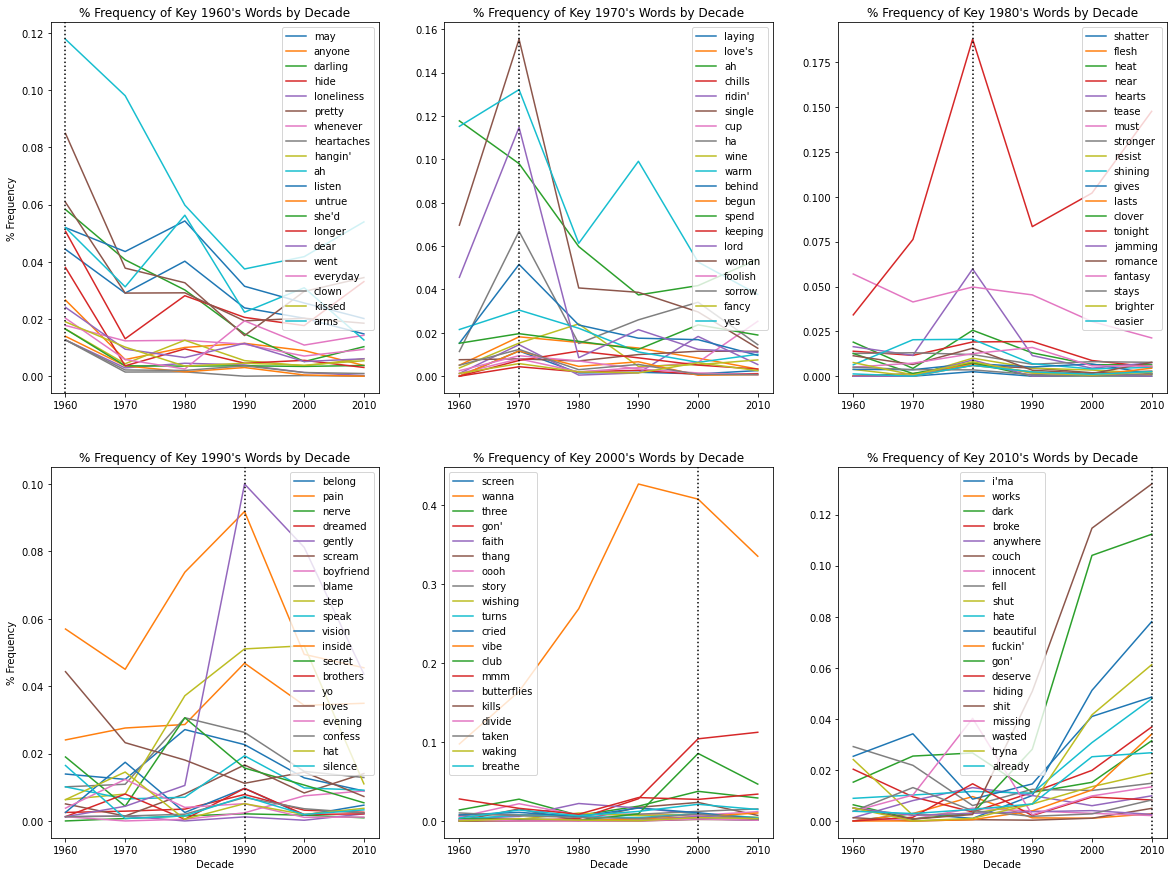

In [21]:
decade_plotter_2by3(key_terms, list(decades), "% Frequency", "Decade", 
                    '% Frequency of Key {}\'s Words by Decade', True, figheight = 15)

In general, I see a peak for each of the terms during the decade that I got them from. However, this is not true for every term, which makes me suspect that not all of these terms are statistically significant.

In [22]:
#extracting the key term dummy variables from all the dummies
key_dum = dummy.loc[:, [term for each_decade in key_terms for term in each_decade]]
#concatenating the key term dummy variables to the main dataframe
key_data = pd.concat([data, key_dum], axis = 1)
#creating dummy for decades
decade_dummy = pd.get_dummies(key_data["decade"])
#concatenating the key_data and the decade dummy variables
key_data = pd.concat([key_data, decade_dummy], axis = 1)

From the key terms, I will extract the significant terms from each decade. Since I'm not able to determine the number of terms that will come out as significant, I will set an arbitrary $\alpha$ = 0.01, and calculate the total error rate afterwards.

In [23]:
'''
this loop will loop through the key terms for each decade, and use the statsmodel library to determine the pvalue for 
each of the key terms, and place them into signif_decade_terms if the term is significant (pval < 0.01)
'''
signif_decade_terms = []
pval = 0.01
for i in range(len(list(decades))):
    #the Patsy library's Q() allows variable name to be taken literally (eg apostrophes won't be problematic)
    decade_terms_string = ' + '.join(["Q(\"" + i + "\")" for i in key_terms[i]])
    formula = f"Q({str(list(decades)[i])}) ~ " + decade_terms_string
    model_dat = smf.logit(formula = formula, data = key_data).fit(maxiter = 10000)
    #model_dat.summary()
    #dir(model_dat)
    p = pd.DataFrame(model_dat.pvalues).reset_index()
    p.columns = ["term", "pval"]
    terms = p.loc[p.pval < pval].term[1:]
    signif_decade_terms.append([re.sub(r'(Q\(\")|(\"\))', '', i) for i in terms])

Optimization terminated successfully.
         Current function value: 0.272481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480349
         Iterations 6


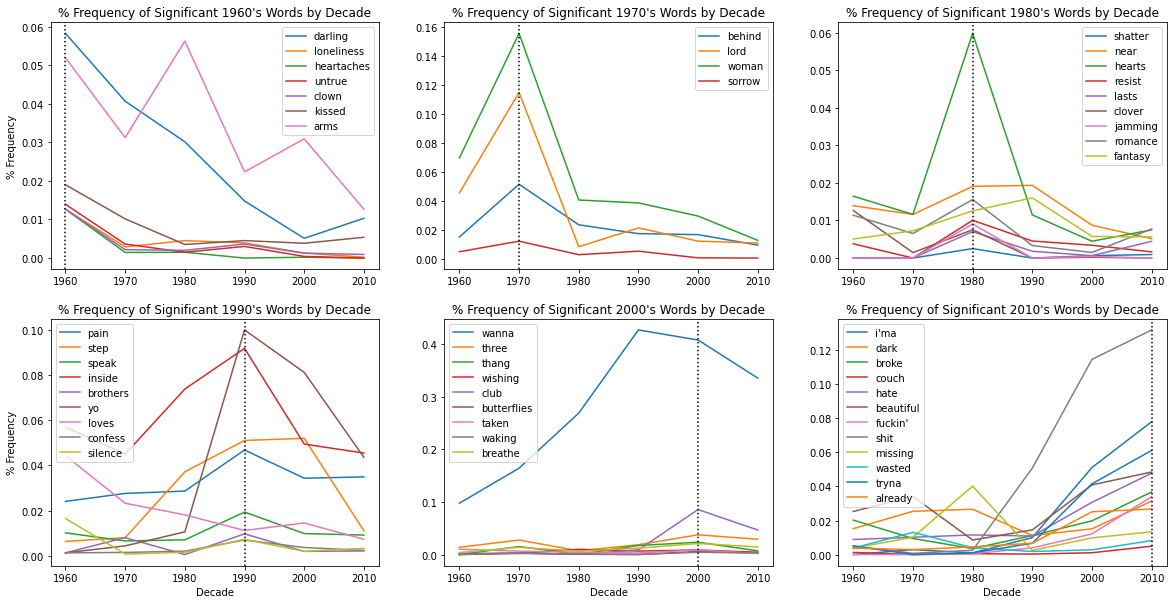

In [24]:
decade_plotter_2by3(signif_decade_terms, list(decades), "% Frequency", "Decade", 
                    '% Frequency of Significant {}\'s Words by Decade', True)

These graphs show the percent frequency of the significant terms for each decade. The black dotted line marks the decade the word is found to be significant, so I expect to see peaks where the vertical lines are. The high percent frequency of 'wanna' in the 2000's unfortunately masks the peaks for the other characteristic terms in that decade, but as a whole, as expected, we see that the majority of terms peaking during the decade that they're found to be characteristic.

In [25]:
signif_dum = dummy[[term for each_decade in signif_decade_terms for term in each_decade]]

In [26]:
reg = LogisticRegression(max_iter = 1000)
model = reg.fit(signif_dum, data["decade"])

In [27]:
def predict(lyrics):
    '''
    this function takes in the lyrics for a song, and returns the predicted decade based on the regression model
    '''
    lyrics = re.sub(r'(\[.*?\]|\,|\.|\!|\?|\"|\(|\)|\{|\})', '', lyrics).lower()
    lyrics = re.sub(r'\n', ' ', lyrics).strip()
    split_lyrics = "".join(lyrics).split() 
    lyrics_dat = [1 if i in split_lyrics else 0 for i in signif_dum.columns]
    df = pd.DataFrame(lyrics_dat).T
    df.columns = signif_dum.columns
    return model.predict(df)[0]

In [28]:
def predict_v2(song, artist):
    '''
    this function takes in the song name and artist name, and obtains the lyrics using the lyricsgenius package and calls
    on the other predict function to return the predicted decade based on the regression model.
    '''
    genius = lg.Genius("JAlCQvWQxOy0Ertp8NhDj4wHzxBwc12vQiToA2HkRFqDHCLOBYTj0DjgrZCldg0f", sleep_time=0.01, verbose = False)
    try:
        locate_song = genius.search_song(song, artist)
        print(f'first 100 characters of lyrics for {song} by {artist} from Genius: \n{locate_song.lyrics[:100]}...\n')
        print(f'The model predicts that this song is from the {predict(locate_song.lyrics)}\'s.')
    except:
        print(f"Lyrics for {song} by {artist} not found.")

The following is an example of using the model to predict the decade of the song "Finesse" by Bruno Mars, released in 2016.

In [29]:
predict_v2("Finesse", "Bruno Mars")

first 100 characters of lyrics for Finesse by Bruno Mars from Genius: 
[Verse 1]
Ooh, don't we look good together?
There's a reason why they watch all night long
Yeah, kno...

The model predicts that this song is from the 2010's.


In [30]:
predictions = data.lyrics.apply(predict)
comp = data.decade == predictions
print(f'model accuracy: {len(comp.loc[comp == True]) / len(comp)*100:.2f}%')
print(f'error rate: {1 - (1 - pval) ** len(signif_decade_terms):.2f}')

model accuracy: 37.67%
error rate: 0.06


### Interpretation and Conclusion ###

#### Analysis Of Mean Word Count ####
From the mean analysis, we see that there is a significant difference between the means of each decade, and that there is a general increase in the average lyric length across the decade. This comes as a bit of a surprise to me, because I don't seem to notice this as a music listener myself. One theory I have that may explain this is the prevalence of faster rap music in the modern decades, leading this higher average word count. Further research may reveal if my theory about the increase in rap music is right, or whether the underlying cause of this is due to increased song length, or a combination of other factors.

#### Analysis of Words ####
When I first explored the percent frequency of words that I sleected based on personal experience, I expected to see a few of these terms to be significant and show up for a certain decade, as seen by the graphs. Although there were overlaps, notably the certain cuss words I previously graphed being characteristic term for the 2010's, I was surprised to see that certain terms didn't make the cut, notably the nature words for the 1960's. This may be due to the fact that other terms were just more prevalent in the 1960's and less prevalent in the other decades, as compared to the nature words I selected. <br><br>
The characteristic terms are as follows:

| Decade | Characteristic Terms                                                                      |
|--------|:-------------------------------------------------------------------------------------------|
| 1960's | darling, loneliness, heartaches, untrue, clown, kissed, arms                              |
| 1970's | behind, lord, woman, sorrow                                                               |
| 1980's | shatter, near, hearts, resist, lasts, clover, jamming, romance, fantasy                   |
| 1990's | pain, step, speak, inside, brothers, yo, loves, confess, silence                          |
| 2000's | wanna, three, thang, wishing, club, butterflies, taken, waking, breathe                   |
| 2010's | i'ma, dark, broke, couch, hate, beautiful, fuckin', shit, missing, wasted, tryna, already |

An interesting tidbit I noticed from the characteristic terms for each decade is that some where thematically linked. The 1960's for example, had 'darling', 'loneliness', and 'heartaches' as characteristic terms, words that have very affectionate and deeply emotional connotations. On the other hand, in the 2010's, we see 'dark', 'broke', 'hate', 'fuckin'', 'shit', and 'wasted' as characteristic terms, which are noticeably darker and more aggressive terms. This may be a reflection of the change in subject matters found within songs, and further sentiment analysis in the future may reveal whether there are true thematic shifts in songs as the decades progress. <br><br>
When creating a model with just the significant terms, the model accuracy was a low 37.67%. Although this is better than a blind guess of 1 out of 6 decades, this low accuracy does not come as a surprise, because the model only had 50 predictors (words), and we know that theres an average of 225 words in a song for just the 1960's which has the lowest average word count. Granted, there may be repetition of certain words, but it doesn't take away from the fact that the model did not have enough predictors. More characteristic terms from each decade can be fed into the model to increase accuracy. The model comes with a familywise error rate of 0.06, which I deem a pretty low number.<br><br>
An improved version of this model, which would more accurately predict which decade a song is from, may be useful to lyricists. Songwriters would be able to determine which decade their lyrics most closely resemble, and potentially use this as one of the factors to keep in mind when producing and marketing songs to a specific generation of listeners. 

### Limitations ###
One big limitation is the size of my data. As shown in the first bargraph, I had less than 400 songs from the 1960s, while about 1000 songs for the 2000s and 2010s, which isn't much either. I started with 1000 titles for each decade, but during the data cleaning, the number of viable songs were gradually whittled down as I eliminated songs without lyrics/songs with incorrect lyrics, erring on the side of more. This may have had an effect on which terms are significant, and which aren't. Another limitation was that I wasn't able to find the p value for all of the predictors due to having not enough memory on my computer, so instead of being able to find all of the significant terms, I focused on finding the significant terms in 20 terms per decade with the largest coefficient. Lastly, there may have been some incorrect lyrics still left in my dataset. I also could have done more manual inspection that may have allowed me to keep more of the correct lyrics when cleaning.

### Acknowledgements ###
Throughout the project, the documentation for each of the libraries and modules I used (especially patsy and sklearn.preprocessing), as well as the Stack Overflow pages that lead me to them, were beneficial in helping me to complete this project

### Source Code ###

[Github Repo](https://github.com/mrkerwinchen/2950_proj)

### Appendix ###
[Data Cleaning](https://github.com/mrkerwinchen/2950_proj/blob/master/Data_Cleaning.ipynb)